In [520]:
!pip install 'networkx==3.0'
!pip install 'scipy==1.9.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [521]:
import networkx as nx
import numpy as np
import torch

In [522]:
# Random test data
import random
num_nodes = 2
radius = [(i + 1) * .1 for i in range(num_nodes)]
labels = [i for i in range(num_nodes)]

In [523]:
G = nx.fast_gnp_random_graph(num_nodes, 0.6)

In [524]:
pos = nx.spring_layout(G)

In [525]:
pos

{0: array([-0.19170954, -1.        ]), 1: array([0.19170954, 1.        ])}

In [526]:
adjacency = nx.adjacency_matrix(G).toarray()
adjacency

array([[0., 0.],
       [0., 0.]])

In [527]:
# Generate bounding box points for training data

def format_box(x1, y1, x2, y2):
  return [min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)]


import math

boxes = np.array([[0, 0, 0, 0]])
for i in range(len(pos)):
  boxes = np.append(boxes, [format_box(pos[i][0] - radius[i], pos[i][1] - radius[i], pos[i][0] + radius[i], pos[i][1] + radius[i])], axis=0)

for i in range(len(adjacency)):
  for j in range(len(adjacency[i])):
    if adjacency[i][j] == 1:
      x1 = pos[i][0]
      y1 = pos[i][1]
      x2 = pos[j][0]
      y2 = pos[j][1]

      second_above = y2 > y1
      second_right = x2 > x1
      slope = (y2 - y1) / (x2 - x1)

      x_delta_abs1 = math.sqrt(radius[i]**2 / (1 + slope**2))
      y_delta_abs1 = abs(slope * x_delta_abs1)

      x_delta_abs2 = math.sqrt(radius[j]**2 / (1 + slope**2))
      y_delta_abs2 = abs(slope * x_delta_abs2)

      box_x1 = x1 + x_delta_abs1 if second_right else x1 - x_delta_abs1
      box_y1 = y1 + y_delta_abs1 if second_above else y1 - y_delta_abs1

      box_x2 = x2 - x_delta_abs2 if second_right else x2 + x_delta_abs2
      box_y2 = y2 - y_delta_abs2 if second_above else y2 + y_delta_abs2

      # boxes = np.append(boxes, [format_box(box_x1, box_y1, box_x2, box_y2)], axis=0)
out = {"labels": torch.Tensor(labels), "boxes": torch.Tensor(boxes)}

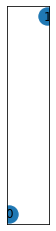

In [528]:
import matplotlib.pyplot as plt
nx.draw_networkx(G, pos)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.axis('on')
plt.savefig("graph.png")

(<Figure size 432x288 with 1 Axes>, <Axes: >)

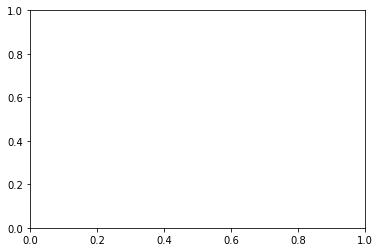

In [529]:
plt.subplots()

In [530]:
out["boxes"]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2917, -1.1000, -0.0917, -0.9000],
        [-0.0083,  0.8000,  0.3917,  1.2000]])

In [531]:
t.shape[1]
t.shape[2]

432

In [532]:
# Display bounding boxes
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as T
from PIL import Image

img = Image.open('graph.png').convert('RGB')
t = T.functional.convert_image_dtype(T.ToTensor()(img), torch.uint8)


# Transform coordinates
for i in range(len(out["boxes"])):
  out["boxes"][i][0] = (out["boxes"][i][0] + 1) * t.shape[2] / 2
  out["boxes"][i][2] = (out["boxes"][i][2] + 1) * t.shape[2] / 2
  out["boxes"][i][1] = (out["boxes"][i][1] + 1) * t.shape[1] / 2
  out["boxes"][i][3] = (out["boxes"][i][3] + 1) * t.shape[1] / 2

out["boxes"]

tensor([[216.0000, 144.0000, 216.0000, 144.0000],
        [152.9907, -14.4000, 196.1907,  14.4000],
        [214.2093, 259.2000, 300.6093, 316.8000]])

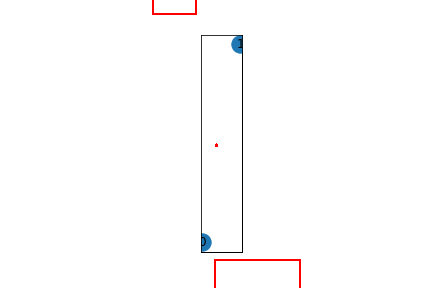

In [533]:
t_boxes = draw_bounding_boxes(t, out["boxes"], colors = 'red', width=2)
img_boxes = T.ToPILImage()(t_boxes)
img_boxes.show()